<a href="https://colab.research.google.com/github/dmt171004/Github_test/blob/main/Visualize_hidden_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt


In [6]:
# Tải tệp kaggle.json lên Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"duongminhtrik18ct","key":"ff40a2a86733fbe3ed847d53d28437f2"}'}

In [7]:
# Tạo thư mục .kaggle và di chuyển tệp kaggle.json vào đó
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Đặt quyền cho tệp kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
# Tải dataset từ Kaggle
!kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:10<00:00, 97.6MB/s]
100% 812M/812M [00:10<00:00, 80.5MB/s]


In [9]:
# Step 3: Extract the Dataset
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Extract train.zip inside the dataset
with zipfile.ZipFile('/content/data/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/train')

In [21]:
# Build the Dense Neural Network
# Tạo mô hình Neural Network với Dense layers
image_size = 64  # Kích thước ảnh (64x64)
model = models.Sequential([
    layers.Flatten(input_shape=(image_size, image_size, 3)),  # Chuyển ảnh thành vector 1D
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer (1 node cho binary classification)
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Step 4: Define Paths
train_dir = '/content/data/train'
batch_size = 32

In [23]:
# Step 5: Create Image Data Generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2  # Split training data into train/validation
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [25]:
# Step 7: Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 1.0000 - loss: 2.5425e-12 - val_accuracy: 1.0000 - val_loss: 2.6636e-13
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 9.3508e-27
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 1.0000 - loss: 5.3646e-12 - val_accuracy: 1.0000 - val_loss: 2.6594e-13
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.6015e-32
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 1.0000 - loss: 1.8237e-11 - val_accuracy: 1.0000 - val_loss: 2.6546e-13


In [26]:
def upload_and_predict():
    """
    Allows the user to upload an image and visualize predictions and learned features.
    """
    from google.colab import files
    uploaded = files.upload()

    for file_name in uploaded.keys():
        # Load và xử lý ảnh
        img = tf.keras.preprocessing.image.load_img(file_name, target_size=(image_size, image_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Dự đoán
        prediction = model.predict(img_array)
        class_label = "Cat" if prediction[0][0] >= 0.5 else "Dog"
        confidence = prediction[0][0]
        print(f"Prediction: {class_label} (Confidence: {confidence:.2f})")

        # Hiển thị features của từng node trong hidden layer
        for layer_idx in range(1, 4):  # Chỉ hiển thị hidden layers (không tính input và output layers)
            print(f"Visualizing features from Layer {layer_idx}:")
            for node_idx in range(5):  # Hiển thị 5 node đầu tiên trong mỗi layer
                visualize_features(layer_idx, node_idx)

In [27]:
def visualize_features(layer_index, node_index):
    """
    Visualize the learned features for a specific node in a specific layer.
    :param layer_index: Index of the layer (e.g., 1 for the first hidden layer).
    :param node_index: Index of the node in the specified layer.
    """
    # Trích xuất trọng số (weights) và bias từ layer được chọn
    weights, biases = model.layers[layer_index].get_weights()

    # Chọn trọng số tương ứng với node (neuron)
    node_weights = weights[:, node_index]

    # Reshape trọng số thành dạng ảnh (nếu có thể)
    try:
        node_image = node_weights.reshape((image_size, image_size, -1))
        plt.imshow(node_image[:, :, 0], cmap='viridis')
        plt.title(f"Features of Node {node_index} in Layer {layer_index}")
        plt.colorbar()
        plt.show()
    except:
        print("Cannot reshape weights into an image format.")

Saving 10000.jpg to 10000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction: Dog (Confidence: 0.00)
Visualizing features from Layer 1:


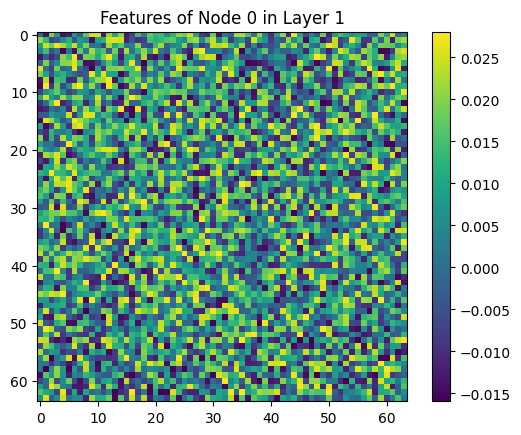

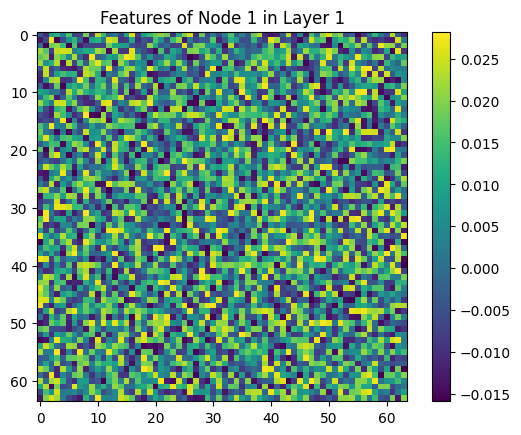

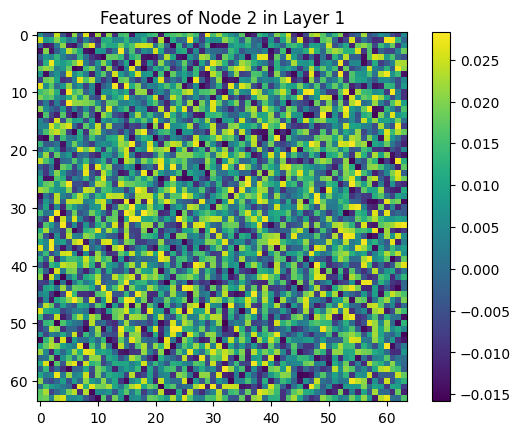

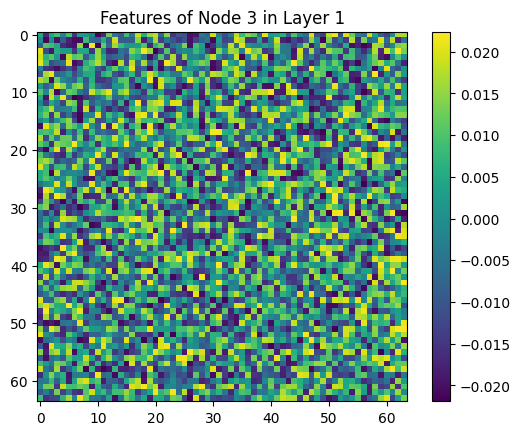

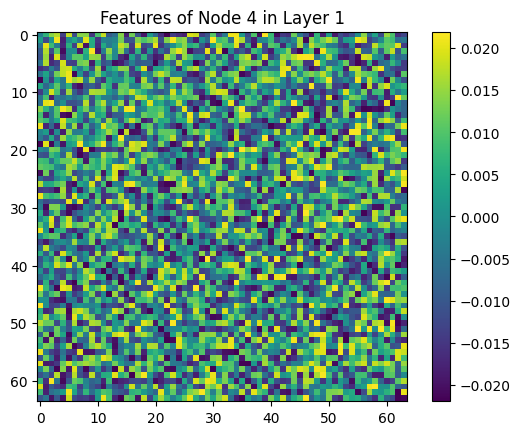

Visualizing features from Layer 2:
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Visualizing features from Layer 3:
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.
Cannot reshape weights into an image format.


In [28]:
# Call upload_and_predict to test
upload_and_predict()